In [1]:
import sys
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/kal/TF_models/bin/')
sys.path.append('/home/thouis/basenji_embeddings')

import tf_memory_limit
from zinb import ZINB
import sequence

import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import datagen
import cg_annotations
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


loading chr1
loading chr10
loading chr11
loading chr12
loading chr13
loading chr14
loading chr15
loading chr16
loading chr17
loading chr18
loading chr19
loading chr2
loading chr20
loading chr21
loading chr22
loading chr3
loading chr4
loading chr5
loading chr6
loading chr7
loading chr8
loading chr9
loading chrM
loading chrX
loading chrY


In [107]:
fbaseline_models = {'3f':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_fold_change.pk', 'rb'))} 
                   #'2f':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_regression_fold_change.pk', 'rb'))}
kbaseline_models = {'3k':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}
                   #'2k':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_regression_k27act_norm.pk', 'rb'))}
fml_models = {'fpwm':load_model('/home/kal/K27act_models/convolution_model/20180706_121935_fold_pwm/final_model.h5')} 
fml_models = {}
kml_models = {'kpwm':load_model('/home/kal/K27act_models/convolution_model/20180706_124549_counts_pwm/final_model.h5'), 
             'kconv':load_model('/home/kal/K27act_models/convolution_model/20180706_125316_counts_conv/final_model.h5')}

In [29]:
#load in data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
peaks.columns='chr start end name score atac k27act nucs'.split()

# get test set
subpeaks = peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)]
cutoff = len(subpeaks)//32
subpeaks=subpeaks[:cutoff*32]
print(len(subpeaks))

3392


In [30]:
# annotated for baseline model
subpeaks['gc_frac'] = subpeaks.apply(cg_annotations.gc_frac, axis=1)
subpeaks['cpg_frac'] = subpeaks.apply(cg_annotations.cpg_frac, axis=1)

In [31]:
# predict baseline model
fbaseline_preds=dict()
for key in fbaseline_models:
    if '3' in key:
        fbaseline_preds[key] = fbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac', 'atac']])
    else:
        fbaseline_preds[key] = fbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac']])

kbaseline_preds=dict()
for key in kbaseline_models:
    if '3' in key:
        kbaseline_preds[key] = kbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac', 'atac']])
    else:
        kbaseline_preds[key] = kbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac']])
    
# extrapolate out the k27 act or the log fold
for key in fbaseline_models:
    kbaseline_preds[key] = (2**(fbaseline_preds[key]))*(subpeaks['atac']+1)-1

for key in kbaseline_models:
    fbaseline_preds[key] = np.log2((kbaseline_preds[key]+1)/(subpeaks['atac']+1))

In [108]:
# predict ml
batch_size=32 

def simple_gen():
    for index, row in subpeaks.iterrows():
        yield datagen.get_sample(row)
        
def simple_batch():
    d = simple_gen()
    while True:
        X = np.empty((batch_size, 1024, 5))
        y = np.empty((batch_size))
        for i in range(batch_size):
            inputs, score = next(d)
            X[i]=inputs
            y[i]=score
        yield X, y
        
ml_fold_preds=dict()
for key in fml_models:
    ml_fold_preds[key] = fml_models[key].predict_generator(simple_batch(), steps=len(subpeaks)//batch_size).flatten()
ml_k27act_preds=dict()
for key in kml_models:
    ml_k27act_preds[key] = kml_models[key].predict_generator(simple_batch(), steps=len(subpeaks)//batch_size).flatten()

# extrapolate out the k27 act or the log fold
for key in fml_models:
    ml_k27act_preds[key] = (2**(ml_fold_preds[key]))*(subpeaks['atac']+1)-1
for key in kml_models:
    ml_fold_preds[key] = np.log2((ml_k27act_preds[key]+1)/(subpeaks['atac']+1))

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log2


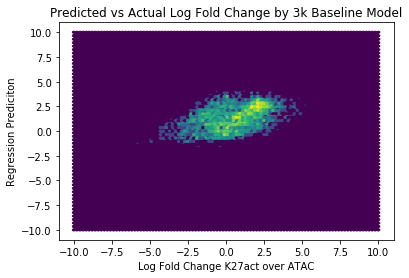

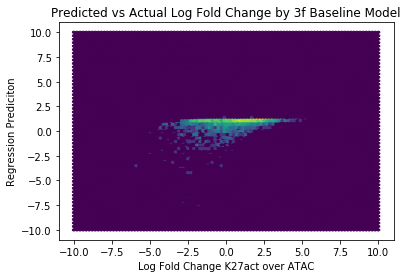

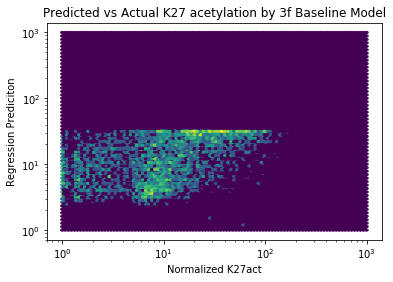

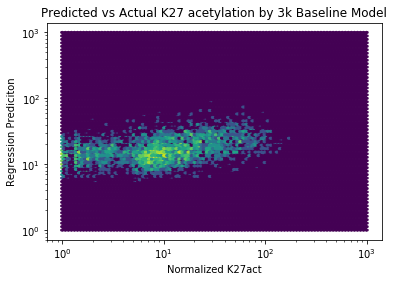

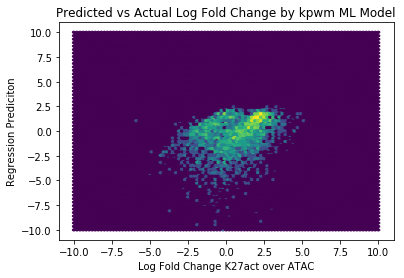

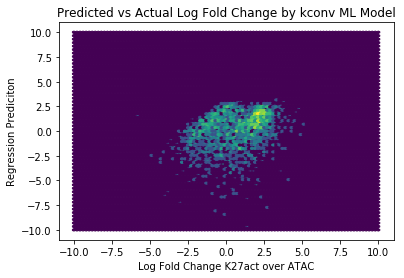

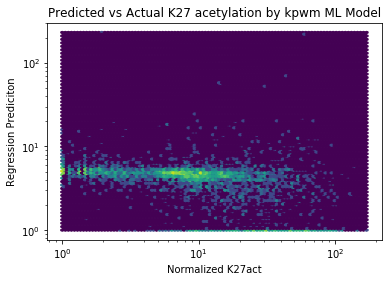

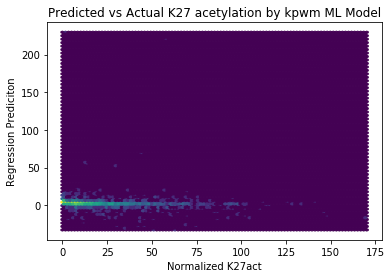

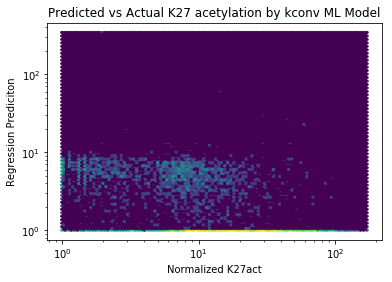

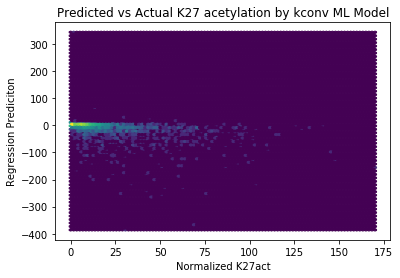

In [109]:
# make some hexbin plots
for key in fbaseline_preds:
    plt.title('Predicted vs Actual Log Fold Change by {} Baseline Model'.format(key))
    plt.xlabel('Log Fold Change K27act over ATAC')
    plt.ylabel('Regression Prediciton')
    plt.hexbin(subpeaks['score'], fbaseline_preds[key], bins='log', extent=(-10, 10, -10, 10))
    plt.show()
    
for key in kbaseline_preds:
    plt.title('Predicted vs Actual K27 acetylation by {} Baseline Model'.format(key))
    plt.xlabel('Normalized K27act')
    plt.ylabel('Regression Prediciton')
    plt.hexbin(subpeaks['k27act'].clip(0)+1, kbaseline_preds[key].clip(0) +1, bins='log', xscale='log', yscale='log', extent=(0, 3, 0, 3))
    plt.show()

for key in ml_fold_preds:
    plt.title('Predicted vs Actual Log Fold Change by {} ML Model'.format(key))
    plt.xlabel('Log Fold Change K27act over ATAC')
    plt.ylabel('Regression Prediciton')
    plt.hexbin(subpeaks['score'], ml_fold_preds[key], bins='log', extent=(-10, 10, -10, 10))
    plt.show()
    
for key in ml_k27act_preds:
    plt.title('Predicted vs Actual K27 acetylation by {} ML Model'.format(key))
    plt.xlabel('Normalized K27act')
    plt.ylabel('Regression Prediciton')
    plt.hexbin(subpeaks['k27act'].clip(0)+1, ml_k27act_preds[key].clip(0) +1, bins='log', xscale='log', yscale='log')
    plt.show()
    
    plt.title('Predicted vs Actual K27 acetylation by {} ML Model'.format(key))
    plt.xlabel('Normalized K27act')
    plt.ylabel('Regression Prediciton')
    plt.hexbin(subpeaks['k27act'], ml_k27act_preds[key], bins='log')
    plt.show()

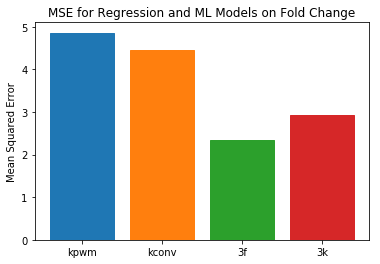

In [119]:
# mse plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
color_iter = iter(colors)
c = dict()
for key in fmse.keys():
    c[key] = next(color_iter)

fmse=dict()
for key in fbaseline_preds:
    fmse[key] = np.mean((subpeaks['score'] - fbaseline_preds[key]) **2)

for key in ml_fold_preds:
    fmse[key] = np.mean((subpeaks['score'] - ml_fold_preds[key]) **2)
    
barlist = plt.bar(range(len(fmse)), fmse.values())
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])

plt.xticks(range(len(fmse)), fmse.keys())
plt.title('MSE for Regression and ML Models on Fold Change')
plt.ylabel('Mean Squared Error')
plt.show()

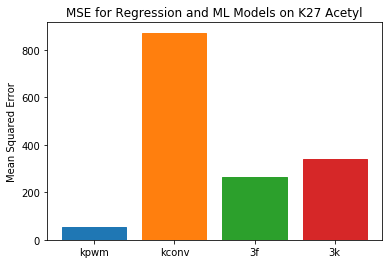

In [121]:
# mse plots
kmse=dict()
for key in kbaseline_preds:
    kmse[key] = np.mean((subpeaks['score'] - kbaseline_preds[key]) **2)

for key in ml_k27act_preds:
    filter = [np.isfinite(m) for m in ml_k27act_preds[key]]
    kmse[key] = np.mean((subpeaks[(filter)]['score'] - ml_k27act_preds[key][(filter)]) **2)
  
barlist = plt.bar(range(len(kmse)), [kmse[k] for k in fmse.keys()])
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])
plt.xticks(range(len(kmse)), fmse.keys())
plt.title('MSE for Regression and ML Models on K27 Acetyl')
plt.ylabel('Mean Squared Error')
plt.show()

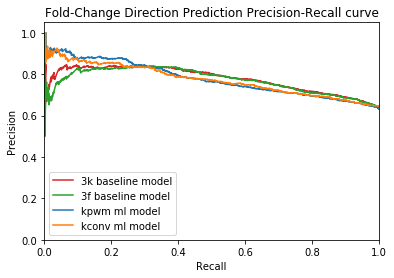

In [123]:
# pr curve
p_base=dict()
r_base=dict()
for key in fbaseline_preds:
    p_base[key], r_base[key], t = precision_recall_curve(subpeaks['score']>0, fbaseline_preds[key])
    plt.plot(r_base[key], p_base[key], label='{} baseline model'.format(key), color=c[key])

p_ml=dict()
r_ml=dict()
for key in ml_fold_preds:
    filter = [np.isfinite(m) for m in ml_fold_preds[key]]
    p_ml[key], r_ml[key], t = precision_recall_curve(subpeaks[filter]['score']>0, ml_fold_preds[key][filter])
    plt.plot(r_ml[key], p_ml[key], label='{} ml model'.format(key), color=c[key])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction Prediction Precision-Recall curve')
plt.show()

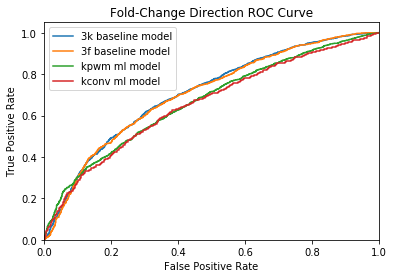

In [124]:
# roc curve
fpr_base=dict()
tpr_base=dict()
for key in fbaseline_preds:
    fpr_base[key], tpr_base[key], t = roc_curve(subpeaks['score']>0, fbaseline_preds[key])
    plt.plot(fpr_base[key], tpr_base[key], label='{} baseline model'.format(key))

fpr_ml=dict()
tpr_ml=dict()
for key in ml_fold_preds:
    filter = [np.isfinite(m) for m in ml_fold_preds[key]]
    fpr_ml[key], tpr_ml[key], t = roc_curve(subpeaks[filter]['score']>0, ml_fold_preds[key][filter])
    plt.plot(fpr_ml[key], tpr_ml[key], label='{} ml model'.format(key))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction ROC Curve')
plt.show()

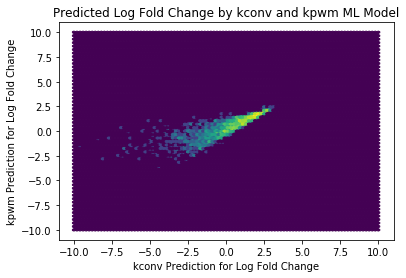

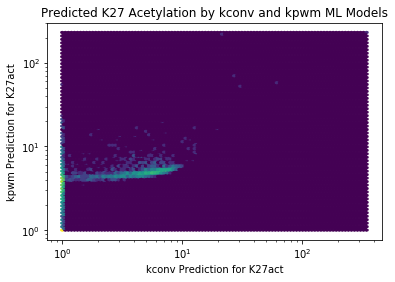

In [126]:
# compare two ml models -- are they picking up on the same things?
key_1 = 'kconv'
key_2 = 'kpwm'

plt.title('Predicted Log Fold Change by {} and {} ML Model'.format(key_1, key_2))
plt.xlabel('{} Prediction for Log Fold Change'.format(key_1))
plt.ylabel('{} Prediction for Log Fold Change'.format(key_2))
plt.hexbin(ml_fold_preds[key_1], ml_fold_preds[key_2], bins='log', extent=(-10, 10, -10, 10))
plt.show()

plt.title('Predicted K27 Acetylation by {} and {} ML Models'.format(key_1, key_2))
plt.xlabel('{} Prediction for K27act'.format(key_1))
plt.ylabel('{} Prediction for K27act'.format(key_2))
plt.hexbin(ml_k27act_preds[key_1].clip(0) +1, ml_k27act_preds[key_2].clip(0) +1, bins='log', xscale='log', yscale='log')
plt.show()

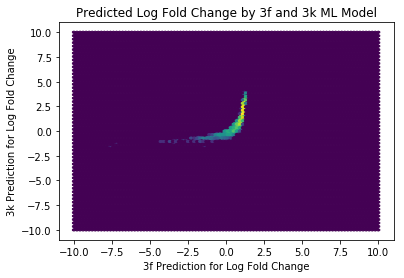

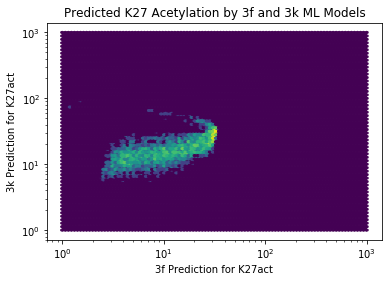

In [27]:
# compare two baseline models -- are they picking up on the same things?
key_1 = '3f'
key_2 = '3k'

plt.title('Predicted Log Fold Change by {} and {} ML Model'.format(key_1, key_2))
plt.xlabel('{} Prediction for Log Fold Change'.format(key_1))
plt.ylabel('{} Prediction for Log Fold Change'.format(key_2))
plt.hexbin(fbaseline_preds[key_1], fbaseline_preds[key_2], bins='log', extent=(-10, 10, -10, 10))
plt.show()

plt.title('Predicted K27 Acetylation by {} and {} ML Models'.format(key_1, key_2))
plt.xlabel('{} Prediction for K27act'.format(key_1))
plt.ylabel('{} Prediction for K27act'.format(key_2))
plt.hexbin(kbaseline_preds[key_1].clip(0) +1, kbaseline_preds[key_2].clip(0) +1, bins='log', xscale='log', yscale='log', extent=(0, 3, 0, 3))
plt.show()

In [ ]:
# get model dreams?? will this even work? 

In [40]:
ml_k27act_preds.keys()

dict_keys(['fpwm'])